# Hyperspectral data analysis and visualization demo

Basically the main analysis and visualization of an hypercube involves the visualization of the single 2D image slices and the spectral profiles.

### 2D images
The images are visualized without further processing or by combining them on using specific equation to obtain specific "spectral indexes" (not yet included in this notebook)

### 2D spectral profiles
Commonly the 2D spectral profiles are plotted and eventually filtered then compared to spectral libraries to look for specific mineral phase signature, etc.
The spectral profiles retreived using the data similar to the one used here, still needs to be further processed in order to remove the noise generated by the continuum (not easy to do, workflows are under development)

**TOC is available on the left panel of Jupyter Lab**

### Requirements
* cufflinks
* fiona
* geopandas
* matplotlib
* numpy
* plotly
* pandas
* scikit-image
* sklearn
* rasterio
* rioxarray
* shapely
* spectral

In [1]:
import cufflinks as cf
from ipywidgets import interact, Button
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import plotly.express as px
from plotly.offline import init_notebook_mode, plot, iplot
import rasterio as rio
import rioxarray as riox
import xarray as xa
from sklearn import preprocessing

# Georeferenced Data
## Open dataset

In [38]:
cube = './M3G20090107T011405_V01_RFL_map.tiff'
cubx = riox.open_rasterio(cube, mask_and_scale=True)

Assign correct wavelengths labels

In [3]:
wavelengths = [ 460.9900 , 500.9200 , 540.8400 , 580.7600 , 620.6900 , 660.6100 , 700.5400 , 730.4800 , 750.4400 , 770.4000 , 790.3700 , 810.3300 , 830.2900 , 850.2500 , 870.2100 , 890.1700 , 910.1400 , 930.1000 , 950.0600 , 970.0200 , 989.9800 , 1009.950 , 1029.910 , 1049.870 , 1069.830 , 1089.790 , 1109.760 , 1129.720 , 1149.680 , 1169.640 , 1189.600 , 1209.570 , 1229.530 , 1249.490 , 1269.450 , 1289.410 , 1309.380 , 1329.340 , 1349.300 , 1369.260 , 1389.220 , 1409.190 , 1429.150 , 1449.110 , 1469.070 , 1489.030 , 1508.990 , 1528.960 , 1548.920 , 1578.860 , 1618.790 , 1658.710 , 1698.630 , 1738.560 , 1778.480 , 1818.400 , 1858.330 , 1898.250 , 1938.180 , 1978.100 , 2018.020 , 2057.950 , 2097.870 , 2137.800 , 2177.720 , 2217.640 , 2257.570 , 2297.490 , 2337.420 , 2377.340 , 2417.260 , 2457.190 , 2497.110 , 2537.030 , 2576.960 , 2616.880 , 2656.810 , 2696.730 , 2736.650 , 2776.580 , 2816.500 , 2856.430 , 2896.350 , 2936.270 , 2976.200 ]

Map numpy index to wavelength labels

In [4]:
index = list(range(0,cubx.shape[0]))
mapped_index = dict(zip(wavelengths, index))

In [5]:
cubx.coords['wavelengths'] = ('band', wavelengths)
cubx 

<xarray.DataArray (band: 85, y: 13278, x: 575)>
[648962250 values with dtype=float32]
Coordinates:
  * band         (band) int64 1 2 3 4 5 6 7 8 9 ... 77 78 79 80 81 82 83 84 85
  * x            (x) float64 -4.991e+04 -4.977e+04 ... 3.031e+04 3.045e+04
  * y            (y) float64 9.048e+05 9.046e+05 ... -9.539e+05 -9.54e+05
    spatial_ref  int64 0
    wavelengths  (band) float64 461.0 500.9 540.8 ... 2.936e+03 2.976e+03

Assign an int value to nodata

In [6]:
nodata = -999

Check if the shape of the data is raster format: band, height, width

In [7]:
cubx.shape

(85, 13278, 575)

Plot a single band or a 3 channel image using internal plot of rioxarray

**By default, band selection is perfomed using numpy index but since we mapped the band index to the proper wavelength we can used the dictionary to select the corresponding index**

In [8]:
# Desired wavelengths can be precise wavelength value or only the integer part
req_wv = [2976, 2616, 770.400]

In [9]:
req_idx = []
for k in mapped_index.keys():    
    for wv in req_wv:
        if wv == int(k) or wv == k:
            req_idx.append(mapped_index[k])
    

In [10]:
R, G, B = req_idx

In [11]:
req_idx

[9, 75, 84]

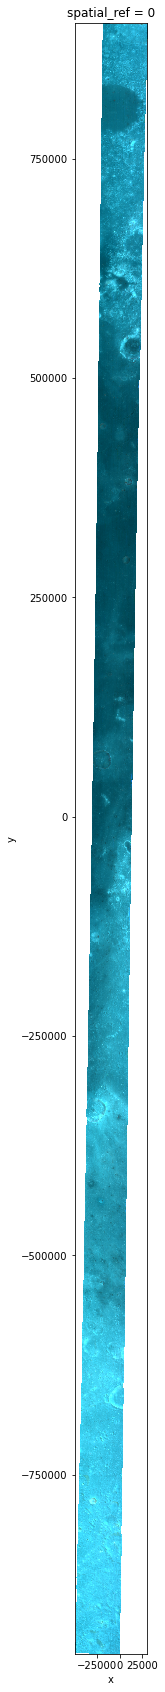

In [12]:
cubx[[R,G,B],:,:].plot.imshow(aspect=cubx.shape[2]/cubx.shape[1], size = 30, robust=True)

### Embedding Wavelength label
We can save direclty the above rgb combination using **cubx[[R,G,B],:,:].rio.to_raster(savename)** but wavelengths information will not be embedded in the metadata. So we create a new xarray datasets and with a for loop add all the channels with proper wavelength information)

In [13]:
rgb_dataset = xa.Dataset()
for idx in req_idx:
    rgb_dataset['Band ' + str(wavelengths[idx])]=cubx[idx,:,:]

Now if we view the xarray dataset the 3 bands are separated and have associated the corresponding wavelength label

rgb_dataset

### Dataset to GeoTiff
Finally, we save the rgb_dataset in a GeoTiff

In [14]:
savename=cube.split('.tiff')[0]+'-rgb.tiff'

In [15]:
rgb_dataset.rio.to_raster(savename)

## Clipping the dataset by region of interest 
Shapefile in this example

In [16]:
from shapely.geometry import mapping
import fiona
import geopandas as gpd

In [17]:
Apollo17_shapefile = "./Shapefile/Apollo17-AREA.shp"
Apollo17_Shape = gpd.read_file(Apollo17_shapefile)#, crs=cubx.rio.crs)

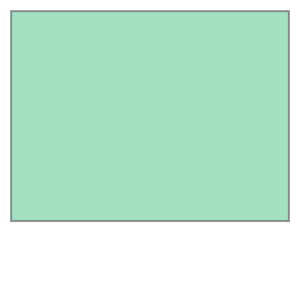

In [18]:
Apollo17_Shape.loc[0].geometry

In [19]:
clipped = cubx.rio.clip(Apollo17_Shape.geometry.apply(mapping), Apollo17_Shape.crs, drop=True)
del cubx

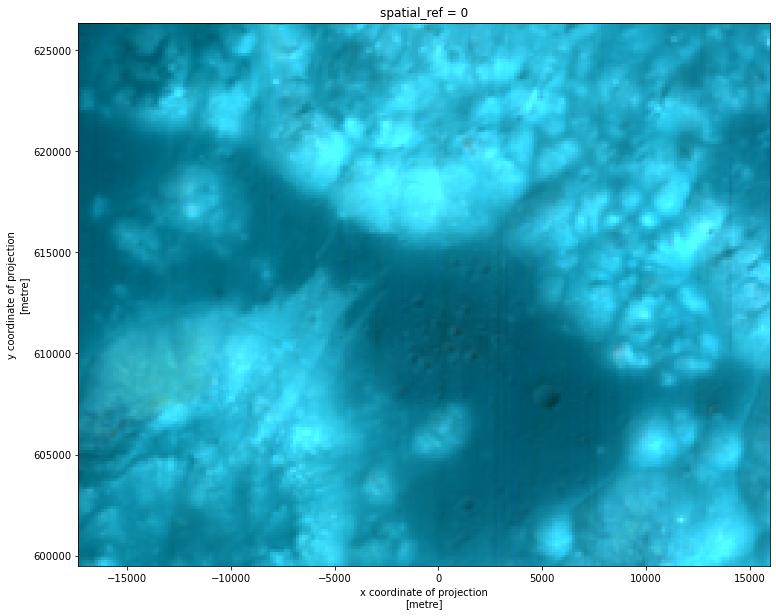

In [20]:
clipped[[R,G,B],:,:].plot.imshow(aspect=clipped.shape[2]/clipped.shape[1], size = 10, robust=True)

## Convert into Pandas DataFrame and dump as CSV

In [21]:
def extract_pixels(X):
    q = X.reshape(-1, X.shape[0])
    df = pd.DataFrame(data = q)
    #df = pd.concat([df, pd.DataFrame(data = y.ravel())], axis=1)
    df.columns= [f'{i}' for i in wavelengths]
    df = df[df!=-999].dropna()
    dataset_name = cube.split('.tiff')[0]+'.csv'
    df.to_csv(dataset_name)
    return df 
df = extract_pixels(clipped.data)

## Plot Spectral Profiles

### Single Interactive profile

In [22]:
init_notebook_mode(connected=True)
cf.go_offline()

In [23]:
invalid_idx = []
for el in range(len(clipped.data)):
    if clipped.data[el].max() == -999:
        invalid_idx.append(el)
wl = [ wavelengths[i] for i in range(len(wavelengths)) if i not in invalid_idx]

Manually select the pixel to be plotted from the clipped cube

In [24]:
x = 50
y = 100
spectral = clipped[:,x,y].data
spectral_reshaped = spectral.reshape(1,-1)
spectral_normalized = preprocessing.normalize(spectral_reshaped)[0]

In [25]:
spectra = [ spectral[i] for i in range(len(spectral)) if i not in invalid_idx]

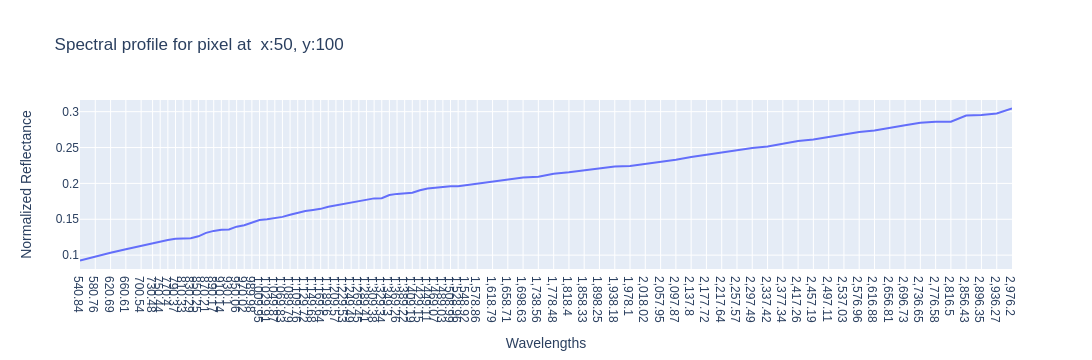

In [26]:
fig = px.line(x=wl, y=spectra,title = f'Spectral profile for pixel at  x:{x}, y:{y}', labels={"y":" Normalized Reflectance","x":"Wavelengths"})
fig.update_layout(
    xaxis = dict(
        tickmode = 'array',
        tickvals= wl,

    )
)
fig.show()

### Dynamic nteractive spectral profiles

In [27]:
extents = [clipped.x.data.min(),clipped.x.data.max(),clipped.y.data.min(),clipped.y.data.max()]

In [28]:
def spectraPlot(pixel_x,pixel_y, baseband):
    reflectance = clipped[:,pixel_x,pixel_y]
    pixel_df = pd.DataFrame()
    pixel_df['reflectance'] = reflectance
    pixel_df['wavelengths'] = wavelengths
    pixel_df = pixel_df[pixel_df!=-999]
    fig = plt.figure(figsize=(20,5))
    ax1 = fig.add_subplot(1,2,1)
    pixel_df.plot(ax=ax1,x='wavelengths',y='reflectance',kind='scatter',edgecolor='none');
    ax1.set_title('Spectra of Pixel (' + str(pixel_x) + ',' + str(pixel_y) + ')')
    ax1.set_xlim([np.min(wl),np.max(wl)]); 
    ax1.set_ylim([np.min(pixel_df['reflectance']),np.max(pixel_df['reflectance']*1.1)])
    ax1.set_xlabel("Wavelength, nm"); ax1.set_ylabel("Reflectance")
    rotatexlabels = plt.setp(ax1.get_xticklabels(),rotation=45)
    ax1.grid('on')

    ax2 = fig.add_subplot(1,2,2)
    plot = plt.imshow(clipped.data[baseband,:,:], extent=extents)
    plt.title('Pixel Location'); 
    ax2.grid('on')
    cbar = plt.colorbar(plot,aspect=20); plt.set_cmap('gist_earth'); 
    cbar.set_label('Reflectance',rotation=90,labelpad=20); 
    ax2.ticklabel_format(useOffset=False, style='plain')
    rotatexlabels = plt.setp(ax2.get_xticklabels(),rotation=45)
    ax2.set_xlabel("Longitutde"); ax2.set_ylabel("Latitude")
    try:
        ax2.plot(clipped[1,pixel_x,pixel_y].coords['x'].data.reshape(1,-1)[0][0],clipped[1,pixel_x,pixel_y].coords['y'].data.reshape(1,-1)[0][0],'s',markersize=5,color='red')
    except Exception as e:
        print(e)
    ax2.set_xlim(extents[0],extents[1])
    ax2.set_ylim(extents[2],extents[3])

In [29]:
interact(spectraPlot, pixel_x = (0,clipped.data.shape[1]-1,1),pixel_y=(0,clipped.data.shape[2]-1,1), baseband=(0,clipped.data.shape[0]-1,1))


interactive(children=(IntSlider(value=95, description='pixel_x', max=191), IntSlider(value=118, description='p…

<function __main__.spectraPlot(pixel_x, pixel_y, baseband)>

## Compute additional analysis e.g. PCA

In [30]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
data_rescaled = scaler.fit_transform(df)

In [31]:
from sklearn.decomposition import PCA
pca = PCA(n_components = 3)
pca.fit(data_rescaled)
reduced = pca.fit_transform(data_rescaled)

In [32]:
dt = pca.fit_transform(df.iloc[:, :-1].values)

In [33]:
pca_df = pd.DataFrame(reduced)

In [34]:
pca_df.columns=['PC1','PC2','PC3']
pca_df

,PC1,PC2,PC3
0,-1.906522,-0.137087,-0.194649
1,-2.228122,0.174710,0.009319
2,-2.526330,-0.315917,-0.010688
3,-1.845543,0.007318,-0.138539
4,-2.404880,0.210950,-0.122654
...,...,...,...
44615,2.908287,0.355769,-0.466801
44616,3.175394,-0.899457,0.394021
44617,2.629644,0.455891,0.429872
44618,2.766367,0.669375,0.304811


In [40]:
import plotly.express as px
fig = px.scatter_3d(pca_df, x ='PC1',y='PC2',z='PC3')
fig.show()

ValueError: Value of 'color' is not the name of a column in 'data_frame'. Expected one of ['PC1', 'PC2', 'PC3'] but received: 10